In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.text_cell_render.rendered_html{font-size:14pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:14px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

# <span style="color:red">ch9_시계열데이터분석</span>
- 라이브러리 이용
- pip install statsmodels==0.13.5 # 주기적인 데이터의 트렌드 추이 분석(예측X)
- pip install prophet  # facebook에서 개발한 시계열 예측 lib(결측치 없는 경우)

In [2]:
# %pip install statsmodels==0.13.5

In [3]:
# %pip install prophet

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
# 한글설정
plt.rc('font', family='Malgun Gothic') # 윈도우즈에서 시각화시 한글 깨짐 방지
plt.rc('axes',unicode_minus=False)     # 축의 '-' 깨짐 방지

In [5]:
# AirKorea 사이트에서 다운로드
df = pd.read_csv('data/일별평균대기오염도_2022(에어코리아).csv', encoding='cp949')
df.tail()

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
18245,20221231,구로구,0.037,0.009,0.5,0.004,43.0,29.0
18246,20221231,광진구,0.026,0.005,0.8,0.003,44.0,34.0
18247,20221231,관악산,0.008,0.038,0.3,0.005,29.0,18.0
18248,20221231,관악구,0.045,0.009,0.7,0.003,42.0,28.0
18249,20221231,공항대로,0.042,0.007,0.7,0.004,41.0,31.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   측정일시          18250 non-null  int64  
 1   측정소명          18250 non-null  object 
 2   이산화질소농도(ppm)  18172 non-null  float64
 3   오존농도(ppm)     18176 non-null  float64
 4   일산화탄소농도(ppm)  18174 non-null  float64
 5   아황산가스농도(ppm)  18176 non-null  float64
 6   미세먼지농도(㎍/㎥)   18115 non-null  float64
 7   초미세먼지농도(㎍/㎥)  18122 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
# 미세먼지농도(㎍/㎥) 결측치인 데이터
df[df['미세먼지농도(㎍/㎥)'].isna()]

# 결측치가 한 열이라도 있는 행
df[df.isna().any(axis=1)]

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
287,20220106,남산,0.033,0.015,0.7,0.004,NaN,NaN
339,20220107,남산,0.039,0.016,0.8,0.005,NaN,NaN
387,20220108,남산,0.048,0.011,0.8,0.004,NaN,NaN
437,20220109,남산,0.027,0.024,1.0,0.003,NaN,NaN
490,20220110,남산,0.049,0.012,1.0,0.003,NaN,NaN
...,...,...,...,...,...,...,...,...
15841,20221113,관악산,0.010,0.022,0.3,0.003,NaN,7.0
15842,20221113,관악구,NaN,NaN,NaN,NaN,NaN,NaN
16503,20221127,행주,NaN,NaN,NaN,NaN,24.0,10.0
16591,20221128,관악산,0.008,0.040,0.2,0.003,NaN,9.0


In [8]:
# 결측치가 한 열이라도 있는 행의 측정소명
df.loc[df.isna().any(axis=1),'측정소명'].unique()

array(['남산', '세곡', '관악산', '마포아트센터', '서대문구', '도산대로', '북한산', '항동', '동작구',
       '서초구', '동작대로', '행주', '올림픽공원', '동대문구', '송파구', '은평구', '한강대로', '강변북로',
       '시흥대로', '성북구', '관악구'], dtype=object)

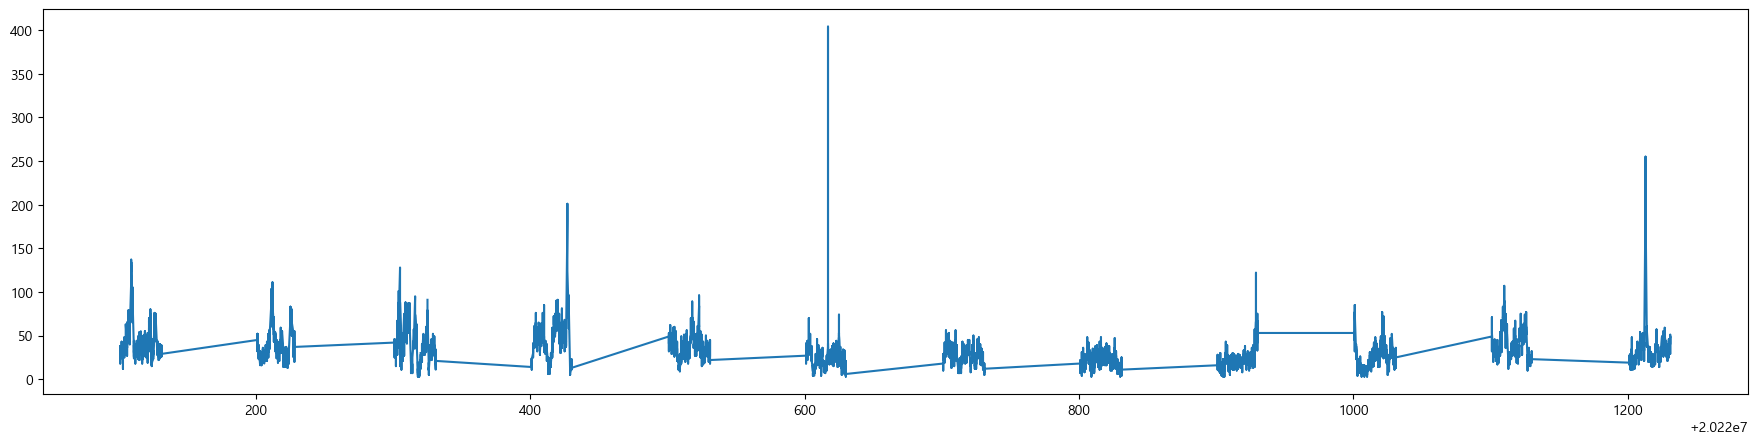

In [9]:
plt.figure(figsize=(22,5))
plt.plot(df['측정일시'], df['미세먼지농도(㎍/㎥)']) # => 측정일시 컬럼이 날짜형이 아님 int64

In [10]:
# 측정일시 컬럼을 날짜형으로 변환 20220101 -> '20220101'(문자)-> '2022-01-01'(날짜)
df['측정일'] = df['측정일시'].astype(str)
df.dtypes

측정일시              int64
측정소명             object
이산화질소농도(ppm)    float64
오존농도(ppm)       float64
일산화탄소농도(ppm)    float64
아황산가스농도(ppm)    float64
미세먼지농도(㎍/㎥)     float64
초미세먼지농도(㎍/㎥)    float64
측정일              object
dtype: object

In [11]:
df.head()

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥),측정일
0,20220101,강남구,0.029,0.014,0.5,0.003,25.0,12.0,20220101
1,20220101,홍릉로,0.038,0.009,0.6,0.004,27.0,16.0,20220101
2,20220101,행주,0.034,0.012,0.7,0.004,27.0,16.0,20220101
3,20220101,항동,0.030,0.011,0.5,0.003,27.0,14.0,20220101
4,20220101,한강대로,0.037,0.011,0.6,0.003,34.0,14.0,20220101


In [12]:
df['측정일'] = df['측정일'].str[:4]+'-'+df['측정일'].str[4:6]+'-'+df['측정일'].str[6:]  # 한번만 수행

In [13]:
df[['측정일시','측정일']].sample()

,측정일시,측정일
15520,20221107,2022-11-07


In [14]:
# df['측정일'].astype('datetime64[ns]')     # 형변환 불가 시 error
df['측정일'] = pd.to_datetime(df['측정일'])  # 형변환 불가 시 결측치로 치환됨

In [15]:
df.dtypes

측정일시                     int64
측정소명                    object
이산화질소농도(ppm)           float64
오존농도(ppm)              float64
일산화탄소농도(ppm)           float64
아황산가스농도(ppm)           float64
미세먼지농도(㎍/㎥)            float64
초미세먼지농도(㎍/㎥)           float64
측정일             datetime64[ns]
dtype: object

In [16]:
# df의 열순서를 변경
cols = df.columns.tolist()
cols = [cols[0], cols[-1]] + cols[1:-1]
df = df[cols]
df.head(1)

,측정일시,측정일,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,20220101,2022-01-01,강남구,0.029,0.014,0.5,0.003,25.0,12.0


In [17]:
df = df.drop('측정일시', axis=1)
df.sample()

,측정일,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
16379,2022-11-24,마포아트센터,0.036,0.015,0.6,0.003,53.0,28.0


In [18]:
df.columns = ['측정일','측정소명','이산화질소농도','오존농도','일산화탄소농도','아황산가스농도','미세먼지농도','초미세먼지농도']
df.sample()

,측정일,측정소명,이산화질소농도,오존농도,일산화탄소농도,아황산가스농도,미세먼지농도,초미세먼지농도
9579,2022-07-11,마포아트센터,0.016,0.055,0.3,0.002,27.0,13.0


In [29]:
# 결측치가 없는 측정소명만 추출
df_flt = df[df['측정소명']=='공항대로']

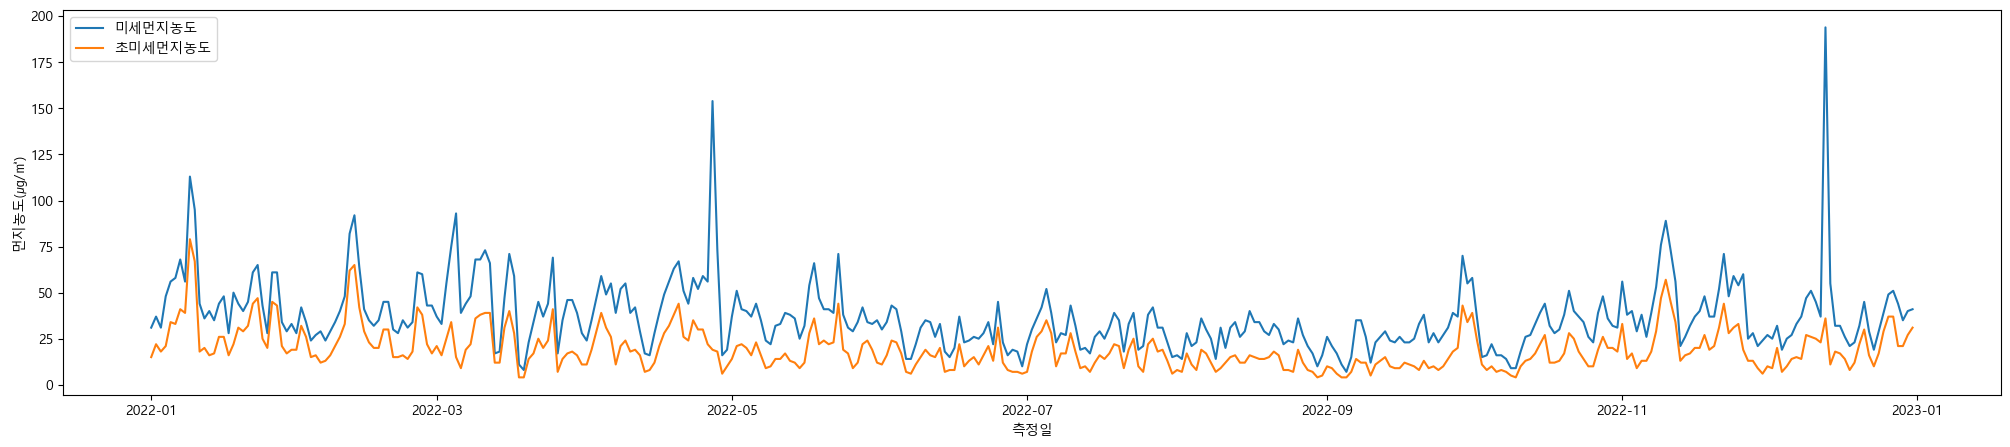

In [30]:
# 미세먼지농도, 초미세먼지농도 시계열 데이터 시각화 (일반 그래프)
plt.figure(figsize=(25,5))
plt.plot(df_flt['측정일'], df_flt['미세먼지농도'], label='미세먼지농도')
plt.plot(df_flt['측정일'], df_flt['초미세먼지농도'], label='초미세먼지농도')
plt.xlabel('측정일')
plt.ylabel('먼지농도(㎍/㎥)')
plt.legend(loc='upper left')
plt.show()

### statsmodels 
- 결측치가 없는 데이터에서 주기적인 데이터의 트랜드 추이
- 날짜형 인덱스와 데이터 컬럼

In [33]:
df_flt2 = df_flt[['측정일','미세먼지농도']]
ts = df_flt2.set_index('측정일')   # 인덱스로
ts.head(3)

,미세먼지농도
측정일,
2022-01-01,31.0
2022-01-02,37.0
2022-01-03,31.0


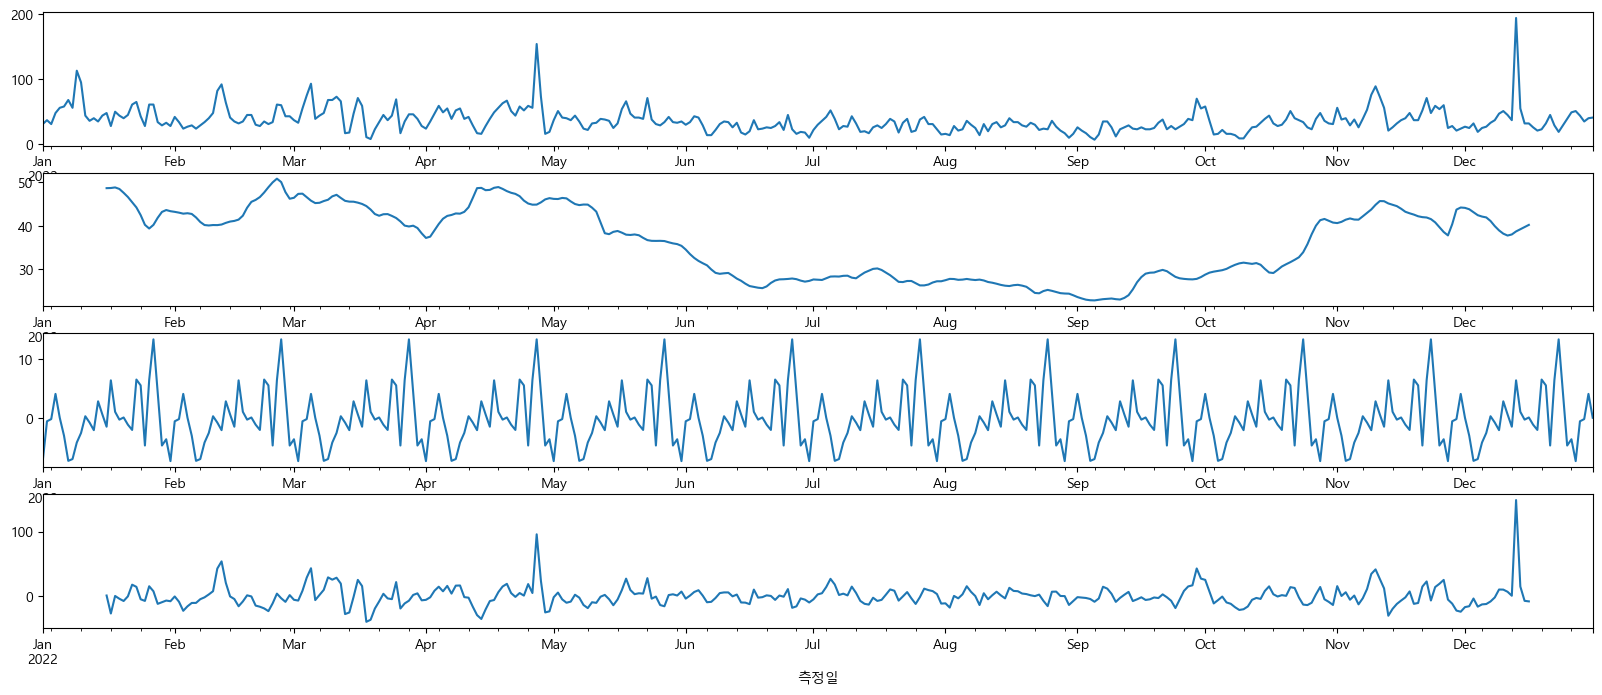

In [44]:
# 시계열 데이터의 구조를 분해하는 도구 : 실제값 추세, 계절성, 잔차를 분석
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['미세먼지농도'],
                           period=30)     # 30일 단위로 계절성을 분석해 봐
# result.observed : 실제 데이터
# result.trend  # 데이터의 장기적인 변화, 전반적으로 감소, 증가
# result.seasonal # 주기적인 계절성 패턴
# result.resid   # 잔차(실제값에서 추세와 계절성을 뺀 노이즈)
fig, axes = plt.subplots(4,1,figsize=(20,8))
# axes[0].plot(result.observed)
result.observed.plot(ax=axes[0])
result.trend.plot(ax=axes[1])
result.seasonal.plot(ax=axes[2])
result.resid.plot(ax=axes[3])
plt.show()

### Prophet
- 계절성, 추세, 휴일효과 등을 자동으로 모델, 예측
- ds(시간), y(시계열성 숫자) 컬럼 (꼭!!)

In [47]:
df_flt2.columns = ['ds','y']  # fit시 컬럼명 ds,y를 읽음
df_flt2.head(1)

,ds,y
44,2022-01-01,31.0


In [48]:
from prophet import Prophet
# 1.모델 생성
p_model = Prophet()
# 2.학습
p_model.fit(df_flt2)

17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing


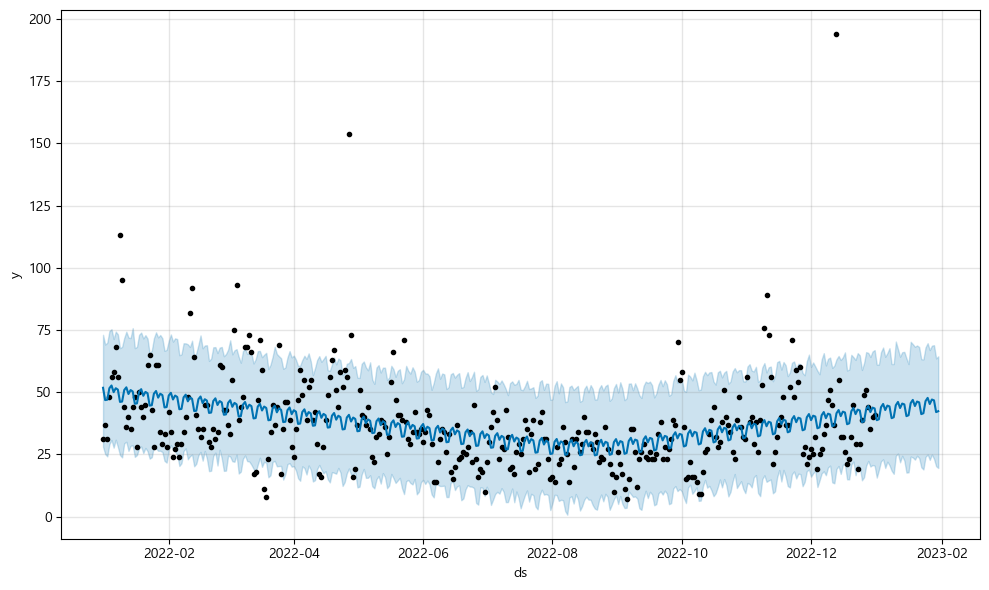

In [54]:
# 3.30일 이후의 데이터를 예측하는 미래 df을 생성
future = p_model.make_future_dataframe(periods=30)
# 4.예측 수행
forecast = p_model.predict(future)
# forecast.tail(30)
# 5. 시각화
p = p_model.plot(forecast)

In [55]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
365,2023-01-01,38.738264,15.658344,61.111902
366,2023-01-02,39.108784,18.727593,61.106609
367,2023-01-03,43.966999,22.222291,66.134062
368,2023-01-04,45.272272,23.008332,67.956331
369,2023-01-05,42.812966,19.526351,64.227166
370,2023-01-06,44.613397,22.038229,65.702417
371,2023-01-07,44.275891,20.617623,67.701584
372,2023-01-08,39.550926,18.444858,61.324558
373,2023-01-09,39.921445,17.167210,61.321951
374,2023-01-10,44.779660,24.411955,70.371008


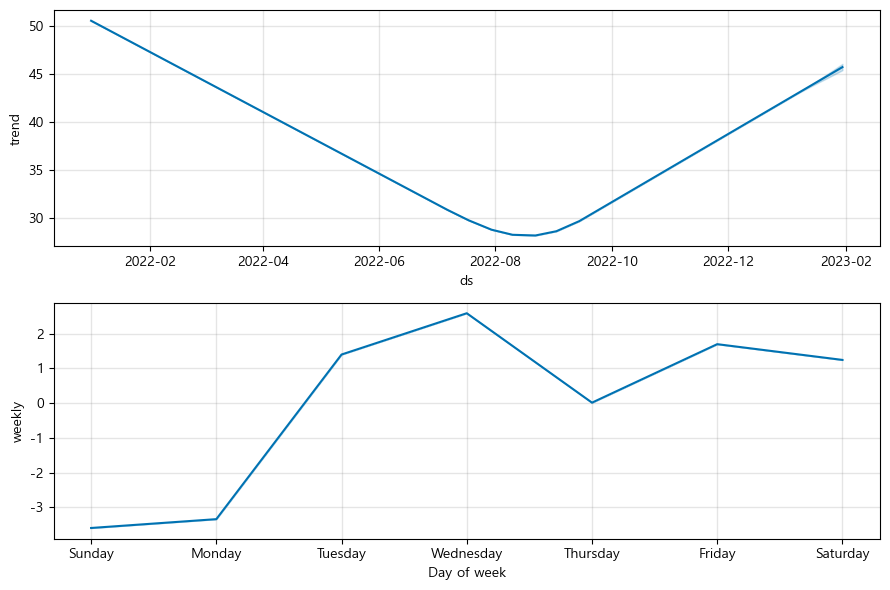

In [57]:
# 트랜드와 휴일 효과
p = p_model.plot_components(forecast)

In [59]:
# 2023-01-12
forecast.loc[forecast['ds'] =='2023-01-06',['ds','yhat']]

,ds,yhat
370,2023-01-06,44.613397
